In [1]:
import re
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

import joblib

In [2]:
import os
os.getcwd()

'C:\\Users\\HP\\Desktop\\promohub-ml\\notebooks'

In [3]:
os.listdir()

['.ipynb_checkpoints', '01_sms_spam_model.ipynb', 'spam_phishing_model.ipynb']

In [4]:
import os
os.listdir("..")

['.git', '.gitignore', 'data', 'models', 'notebooks', 'README.md', 'src']

In [5]:
os.listdir("../data/raw")

['.ipynb_checkpoints',
 'credit-card-fraud',
 'phishing dataset',
 'sms dataset',
 'Training Dataset.arff']

In [8]:
os.listdir("../data/raw/phishing dataset")

['.ipynb_checkpoints',
 '.old.arff',
 'Phishing Websites Features.docx',
 'Training Dataset.arff']

In [9]:
from scipy.io import arff
import pandas as pd

data, meta = arff.loadarff("../data/raw/phishing dataset/Training Dataset.arff")
df = pd.DataFrame(data)

print(df.shape)
df.head()

(11055, 31)


,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,b'-1',b'1',b'1',b'1',b'-1',b'-1',b'-1',b'-1',b'-1',b'1',...,b'1',b'1',b'-1',b'-1',b'-1',b'-1',b'1',b'1',b'-1',b'-1'
1,b'1',b'1',b'1',b'1',b'1',b'-1',b'0',b'1',b'-1',b'1',...,b'1',b'1',b'-1',b'-1',b'0',b'-1',b'1',b'1',b'1',b'-1'
2,b'1',b'0',b'1',b'1',b'1',b'-1',b'-1',b'-1',b'-1',b'1',...,b'1',b'1',b'1',b'-1',b'1',b'-1',b'1',b'0',b'-1',b'-1'
3,b'1',b'0',b'1',b'1',b'1',b'-1',b'-1',b'-1',b'1',b'1',...,b'1',b'1',b'-1',b'-1',b'1',b'-1',b'1',b'-1',b'1',b'-1'
4,b'1',b'0',b'-1',b'1',b'1',b'-1',b'1',b'1',b'-1',b'1',...,b'-1',b'1',b'-1',b'-1',b'0',b'-1',b'1',b'1',b'1',b'1'


In [10]:
import pandas as pd
import numpy as np


df.columns = [str(c).strip() for c in df.columns]

bad_cols = [c for c in df.columns if "Resulthaving_IP_Address" in c or c.endswith("}")]  # sometimes ARFF artifacts
if bad_cols:
    df = df.drop(columns=bad_cols)

target_candidates = [c for c in df.columns if c.lower().strip() == "result"]
if not target_candidates:
    raise ValueError(f"Could not find target column 'Result'. Columns are: {df.columns.tolist()[:30]}")
TARGET = target_candidates[0]


for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df = df.dropna(subset=[TARGET]).copy()
df = df.dropna().copy()

print("Shape:", df.shape)
print("Target column:", TARGET)
print("Target distribution:\n", df[TARGET].value_counts())
df.head()

Shape: (11055, 31)
Target column: Result
Target distribution:
 Result
 1    6157
-1    4898
Name: count, dtype: int64


,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,-1,1,1,1,-1,-1,-1,-1,-1,1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,1,1,1,1,1,-1,0,1,-1,1,...,1,1,-1,-1,0,-1,1,1,1,-1
2,1,0,1,1,1,-1,-1,-1,-1,1,...,1,1,1,-1,1,-1,1,0,-1,-1
3,1,0,1,1,1,-1,-1,-1,1,1,...,1,1,-1,-1,1,-1,1,-1,1,-1
4,1,0,-1,1,1,-1,1,1,-1,1,...,-1,1,-1,-1,0,-1,1,1,1,1


In [11]:
print(df.describe().T.head(15))
print("\nMissing values per column (top 15):")
print(df.isna().sum().sort_values(ascending=False).head(15))

                               count      mean       std  min  25%  50%  75%  \
having_IP_Address            11055.0  0.313795  0.949534 -1.0 -1.0  1.0  1.0   
URL_Length                   11055.0 -0.633198  0.766095 -1.0 -1.0 -1.0 -1.0   
Shortining_Service           11055.0  0.738761  0.673998 -1.0  1.0  1.0  1.0   
having_At_Symbol             11055.0  0.700588  0.713598 -1.0  1.0  1.0  1.0   
double_slash_redirecting     11055.0  0.741474  0.671011 -1.0  1.0  1.0  1.0   
Prefix_Suffix                11055.0 -0.734962  0.678139 -1.0 -1.0 -1.0 -1.0   
having_Sub_Domain            11055.0  0.063953  0.817518 -1.0 -1.0  0.0  1.0   
SSLfinal_State               11055.0  0.250927  0.911892 -1.0 -1.0  1.0  1.0   
Domain_registeration_length  11055.0 -0.336771  0.941629 -1.0 -1.0 -1.0  1.0   
Favicon                      11055.0  0.628584  0.777777 -1.0  1.0  1.0  1.0   
port                         11055.0  0.728268  0.685324 -1.0  1.0  1.0  1.0   
HTTPS_token                  11055.0  0.

In [12]:
import matplotlib.pyplot as plt

corr = df.corr(numeric_only=True)

print("Correlation matrix shape:", corr.shape)
corr.iloc[:8, :8]

Correlation matrix shape: (31, 31)


,having_IP_Address,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State
having_IP_Address,1.000000,-0.052411,0.403461,0.158699,0.397389,-0.005257,-0.080745,0.071414
URL_Length,-0.052411,1.000000,-0.097881,-0.075108,-0.081247,0.055247,0.003997,0.048754
Shortining_Service,0.403461,-0.097881,1.000000,0.104447,0.842796,-0.080471,-0.041916,-0.061426
having_At_Symbol,0.158699,-0.075108,0.104447,1.000000,0.086960,-0.011726,-0.058976,0.031220
double_slash_redirecting,0.397389,-0.081247,0.842796,0.086960,1.000000,-0.085590,-0.043079,-0.036200
Prefix_Suffix,-0.005257,0.055247,-0.080471,-0.011726,-0.085590,1.000000,0.087891,0.261391
having_Sub_Domain,-0.080745,0.003997,-0.041916,-0.058976,-0.043079,0.087891,1.000000,0.267649
SSLfinal_State,0.071414,0.048754,-0.061426,0.031220,-0.036200,0.261391,0.267649,1.000000


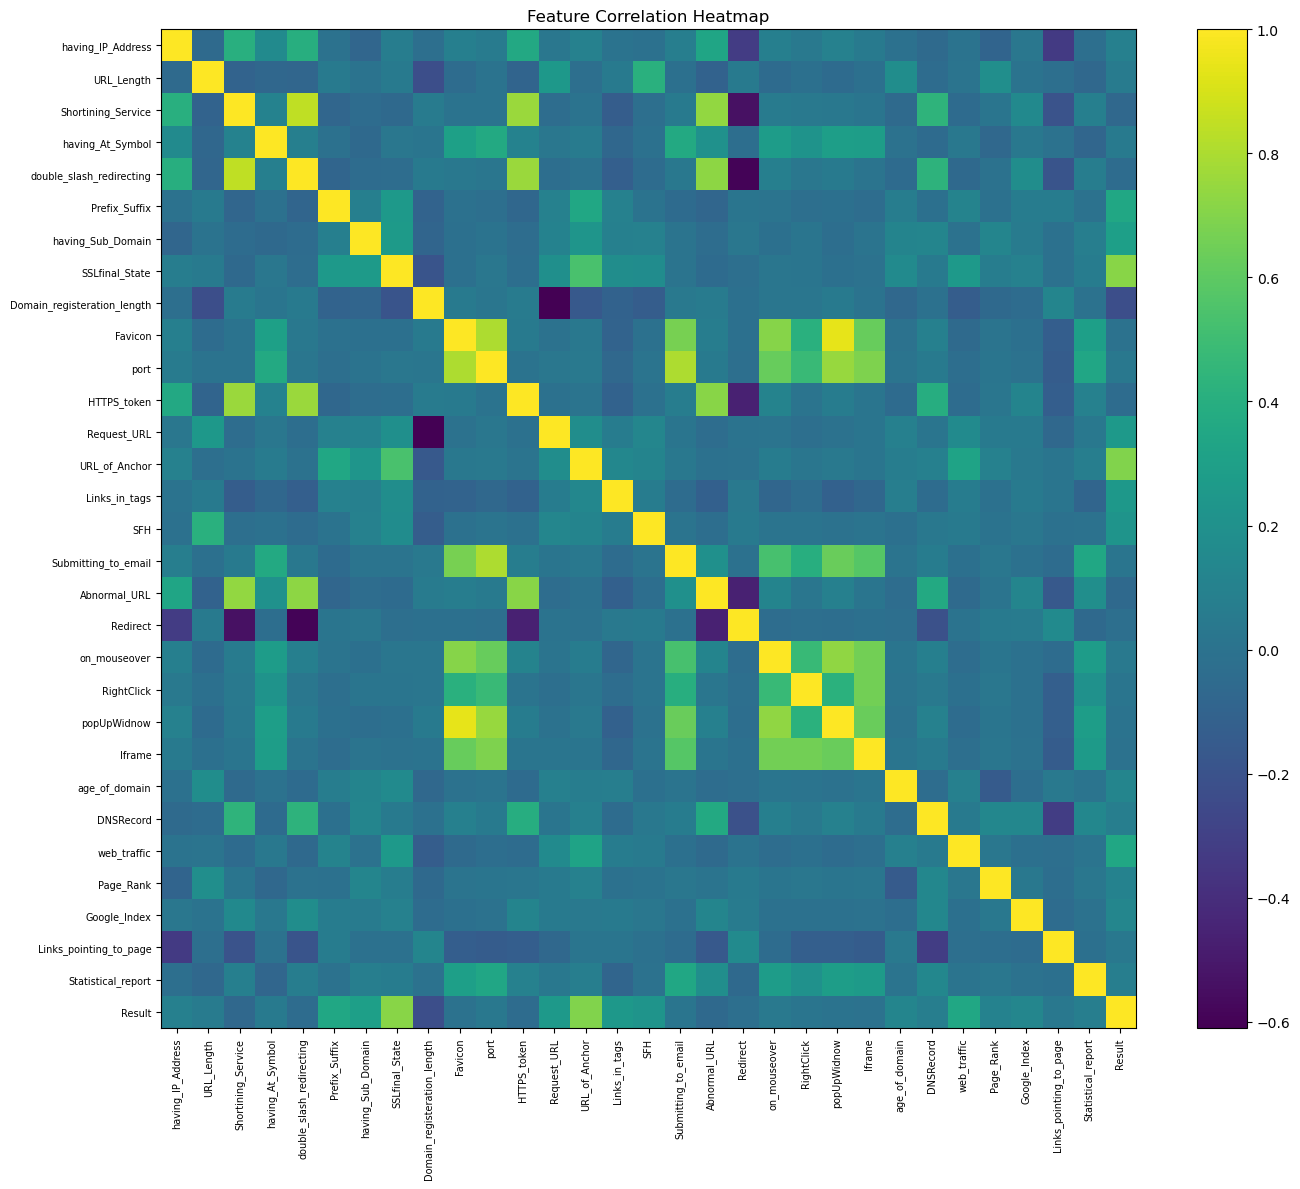

In [13]:
plt.figure(figsize=(14, 12))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.title("Feature Correlation Heatmap")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=7)
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=7)
plt.tight_layout()
plt.show()

In [14]:
target_corr = corr[TARGET].sort_values(ascending=False)
print("Top positive correlations with Result:")
print(target_corr.head(12))

print("\nTop negative correlations with Result:")
print(target_corr.tail(12))

Top positive correlations with Result:
Result               1.000000
SSLfinal_State       0.714741
URL_of_Anchor        0.692935
Prefix_Suffix        0.348606
web_traffic          0.346103
having_Sub_Domain    0.298323
Request_URL          0.253372
Links_in_tags        0.248229
SFH                  0.221419
Google_Index         0.128950
age_of_domain        0.121496
Page_Rank            0.104645
Name: Result, dtype: float64

Top negative correlations with Result:
Links_pointing_to_page         0.032574
Submitting_to_email            0.018249
RightClick                     0.012653
popUpWidnow                    0.000086
Favicon                       -0.000280
Iframe                        -0.003394
Redirect                      -0.020113
double_slash_redirecting      -0.038608
HTTPS_token                   -0.039854
Abnormal_URL                  -0.060488
Shortining_Service            -0.067966
Domain_registeration_length   -0.225789
Name: Result, dtype: float64


In [15]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)
print("Train target distribution:\n", y_train.value_counts())

Train: (8844, 30) Test: (2211, 30)
Train target distribution:
 Result
 1    4926
-1    3918
Name: count, dtype: int64


In [16]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
])

logreg.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=2000))])

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    class_weight="balanced_subsample",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1
)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', n_estimators=400,
                       n_jobs=-1, random_state=42)


===== Logistic Regression =====
              precision    recall  f1-score   support

          -1       0.92      0.92      0.92       980
           1       0.93      0.94      0.94      1231

    accuracy                           0.93      2211
   macro avg       0.93      0.93      0.93      2211
weighted avg       0.93      0.93      0.93      2211



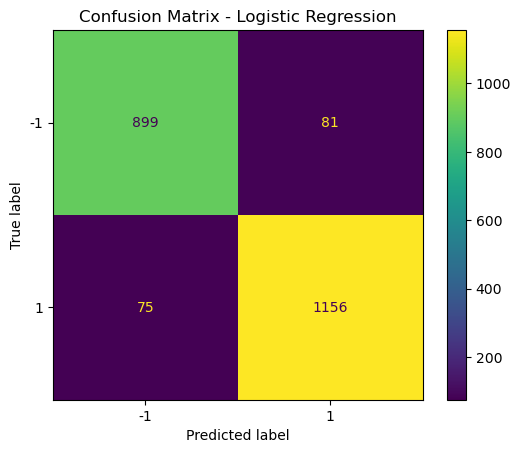

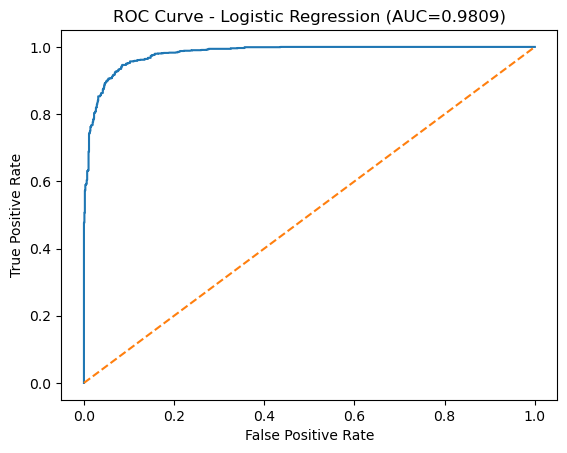

AUC (class 1 as positive): 0.9809

===== Random Forest =====
              precision    recall  f1-score   support

          -1       0.98      0.97      0.97       980
           1       0.97      0.98      0.98      1231

    accuracy                           0.98      2211
   macro avg       0.98      0.97      0.97      2211
weighted avg       0.98      0.98      0.98      2211



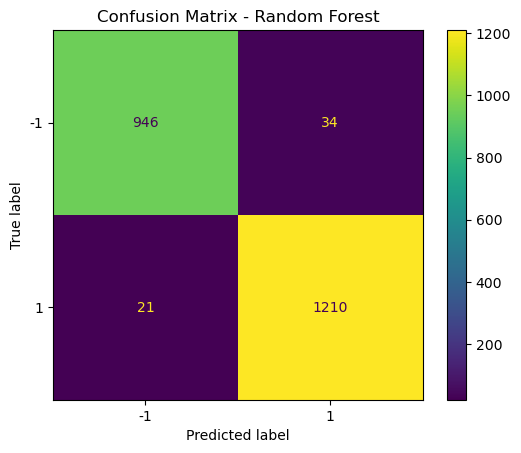

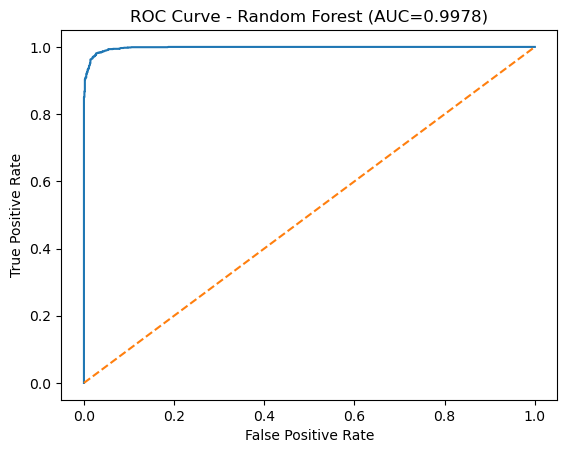

AUC (class 1 as positive): 0.9978


In [18]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve

def evaluate(model, X_test, y_test, title="Model"):
    pred = model.predict(X_test)
    print(f"\n===== {title} =====")
    print(classification_report(y_test, pred))

    cm = confusion_matrix(y_test, pred, labels=sorted(y_test.unique()))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(y_test.unique()))
    disp.plot()
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

    # ROC only if model has predict_proba or decision_function
    y_true = (y_test == 1).astype(int)  # treat class 1 as "positive" (legit) by default
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X_test)[:, list(model.classes_).index(1)]
        auc = roc_auc_score(y_true, scores)
        fpr, tpr, _ = roc_curve(y_true, scores)
        plt.figure()
        plt.plot(fpr, tpr)
        plt.plot([0,1], [0,1], linestyle="--")
        plt.title(f"ROC Curve - {title} (AUC={auc:.4f})")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.show()
        print(f"AUC (class 1 as positive): {auc:.4f}")

evaluate(logreg, X_test, y_test, "Logistic Regression")
evaluate(rf, X_test, y_test, "Random Forest")

SSLfinal_State                 0.308606
URL_of_Anchor                  0.241937
web_traffic                    0.074269
having_Sub_Domain              0.067178
Prefix_Suffix                  0.046827
Links_in_tags                  0.045940
SFH                            0.022047
Request_URL                    0.020024
Links_pointing_to_page         0.019483
Domain_registeration_length    0.016551
age_of_domain                  0.016094
having_IP_Address              0.013639
Google_Index                   0.012851
DNSRecord                      0.012750
Page_Rank                      0.011973
URL_Length                     0.009018
HTTPS_token                    0.006121
Redirect                       0.006018
Submitting_to_email            0.005636
Shortining_Service             0.005501
dtype: float64


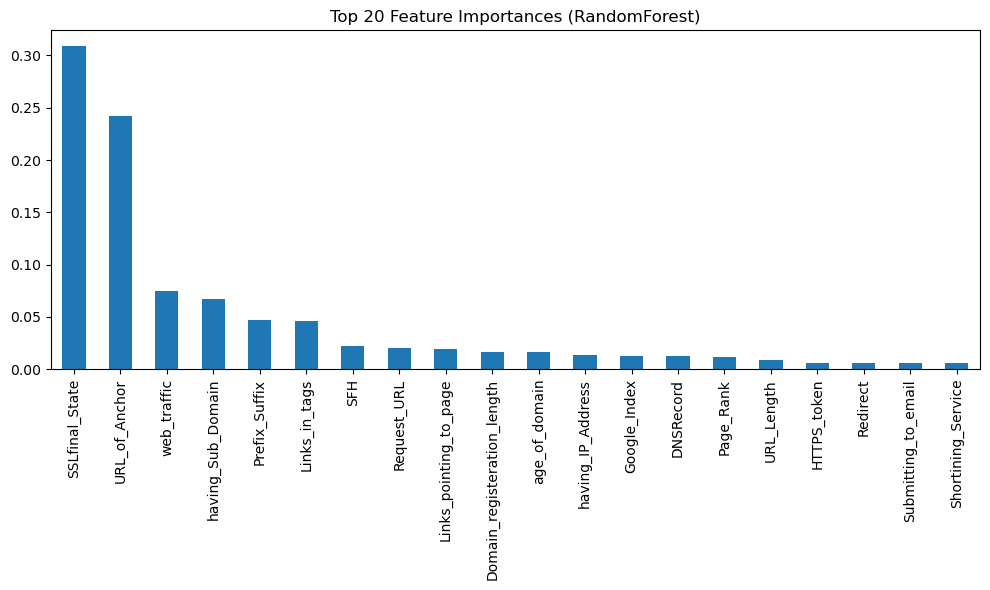

In [19]:
import pandas as pd

importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print(importances.head(20))

plt.figure(figsize=(10,6))
importances.head(20).plot(kind="bar")
plt.title("Top 20 Feature Importances (RandomForest)")
plt.tight_layout()
plt.show()

In [20]:
import joblib

joblib.dump(rf, "phishing_url_feature_model.joblib")
print("Saved: phishing_url_feature_model.joblib")

joblib.dump(logreg, "phishing_url_feature_logreg.joblib")
print("Saved: phishing_url_feature_logreg.joblib")

Saved: phishing_url_feature_model.joblib
Saved: phishing_url_feature_logreg.joblib


In [21]:
loaded = joblib.load("phishing_url_feature_model.joblib")

sample = X_test.iloc[[0]]   # keep as DataFrame
print("True label:", y_test.iloc[0])
print("Prediction:", loaded.predict(sample)[0])

True label: -1
Prediction: -1


In [22]:
if hasattr(loaded, "predict_proba"):
    proba = loaded.predict_proba(sample)
    print("Classes:", loaded.classes_)
    print("Probabilities:", proba)

Classes: [-1  1]
Probabilities: [[1. 0.]]
